In [ ]:
"""
ДЗ 1. Блок 2. Анализ и обработка данных. Раздел 3. Очистка данных.

Пропуски во временных рядах.
"""

'Missing in time sequences.'

# Пропуски во временных рядах

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# fmt: off
# isort: skip_file        
# pyupgrade: disable      
# pylint: skip-file       
# flake8: noqa           
# mypy: ignore-errors     
# codespell:disable

In [3]:
sns.set(rc = {'figure.figsize' : (10, 6)})

### Подготовка данных

In [4]:
# импортируем датасеты
passengers = pd.read_csv('../content/passengers.csv')
births = pd.read_csv('../content/births.csv')
passengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


#### Добавление пропусков

In [5]:
import random

random.seed(1)

# переименуем столбец #Passengers в reference
passengers.rename(columns = {'#Passengers' : 'reference'}, inplace = True)

# сделаем две копии этого столбца с названиями target и missing
passengers['target'] = passengers.reference
passengers['missing'] = passengers.reference

# посчитаем количество наблюдений
n_samples = len(passengers)
# вычислим 20 процентов от этого числа,
# это будет количество пропусков
how_many = int(0.20 * n_samples)

# случайным образом выберем 20 процентов значений индекса
mask_target = random.sample(list(passengers.index), how_many)
# и заполним их значением NaN в столбце target
passengers.iloc[mask_target, 2] = np.nan

# найдем оставшиеся значения индекса
mask_missing = list(set(passengers.index) - set(mask_target))
# сделаем их NaN и поместим в столбец missing
passengers.iloc[mask_missing, 3] = np.nan

# переведем столбец Month в формат datetime
passengers.index = pd.to_datetime(passengers.Month)
passengers.drop(columns = ['Month'], inplace = True)

In [6]:
# посчитаем количество пропусков в каждом столбце
passengers.isnull().sum()

reference      0
target        28
missing      116
dtype: int64

In [7]:
passengers.head(3)

,reference,target,missing
Month,,,
1949-01-01,112,NaN,112.0
1949-02-01,118,118.0,NaN
1949-03-01,132,NaN,132.0


In [8]:
random.seed(1)

births.rename(columns = {'Births' : 'reference'}, inplace = True)
births['target'] = births.reference
births['missing'] = births.reference

n_samples = len(births)
how_many = int(0.15 * n_samples)

mask_target = random.sample(list(births.index), how_many)
births.iloc[mask_target, 2] = np.nan

mask_missing = list(set(births.index) - set(mask_target))
births.iloc[mask_missing, 3] = np.nan

births.index = pd.to_datetime(births.Date)
births.drop(columns = ['Date'], inplace = True)

In [9]:
births.isnull().sum()

reference      0
target        54
missing      311
dtype: int64

In [10]:
births.head(3)

,reference,target,missing
Date,,,
1959-01-01,35,35.0,NaN
1959-01-02,32,NaN,32.0
1959-01-03,30,30.0,NaN


#### Визуализация пропусков

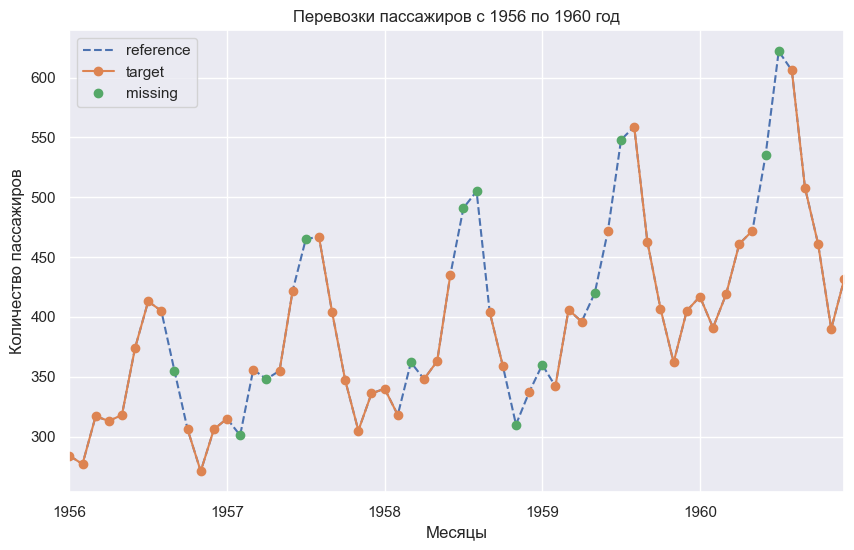

In [11]:
# сократим временной ряд
passengers = passengers['1956-01':'1960-12']

ax = passengers.plot(style=['--', 'o-', 'o'])
ax.set(title = 'Перевозки пассажиров с 1956 по 1960 год',
       xlabel = 'Месяцы',
       ylabel = 'Количество пассажиров');

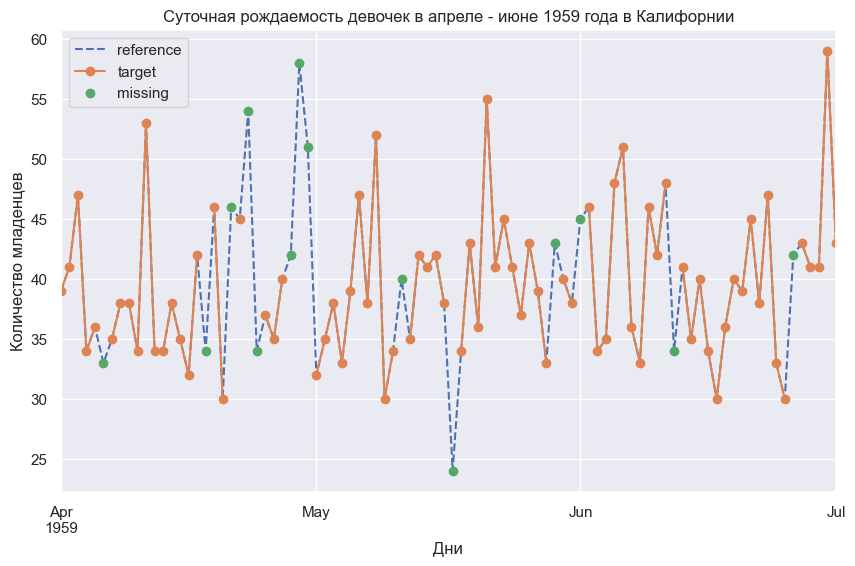

In [12]:
# данные о рождаемости также сократим
births = births['1959-04-01':'1959-07-01']

ax = births.plot(style=['--', 'o-', 'o'])
ax.set(title = 'Суточная рождаемость девочек в апреле - июне 1959 года в Калифорнии',
       xlabel = 'Дни',
       ylabel = 'Количество младенцев');

### Заполнение средним и медианой

In [13]:
# передадим в метод .fillna() среднее арифметическое и медиану
passengers = passengers.assign(FillMean = passengers.target.fillna(passengers.target.mean()))
passengers = passengers.assign(FillMedian = passengers.target.fillna(passengers.target.median()))

In [14]:
# сделаем то же самое для данных о рождаемости
births = births.assign(FillMean = births.target.fillna(births.target.mean()))
births = births.assign(FillMedian = births.target.fillna(births.target.median()))

### Заполнение предыдущим и последующим значениями

In [15]:
# заполним пропуски предыдущим значением
passengers = passengers.assign(FFill = passengers.target.ffill())
births = births.assign(FFill = births.target.ffill())

In [16]:
# заполним пропуски последующим значением
passengers = passengers.assign(BFill = passengers.target.bfill())
births = births.assign(BFill = births.target.bfill())

### Заполнение скользящим средним и медианой

In [17]:
# рассчитаем скользящее среднее и медиану для данных о пассажирах
passengers = passengers.assign(RollingMean =
                               passengers.target.fillna(
                                   passengers.target.rolling(window = 5,
                                                             min_periods = 1).mean()))

passengers = passengers.assign(RollingMedian =
                               passengers.target.fillna(
                                   passengers.target.rolling(window = 5,
                                                             min_periods = 1).median()))

In [18]:
# рассчитаем скользящее среднее и медиану для данных о рождаемости
births = births.assign(RollingMean =
                       births.target.fillna(
                           births.target.rolling(window = 5,
                                                 min_periods = 1).mean()))

births = births.assign(RollingMedian =
                       births.target.fillna(
                           births.target.rolling(window = 5,
                                                 min_periods = 1).median()))

### Интерполяция

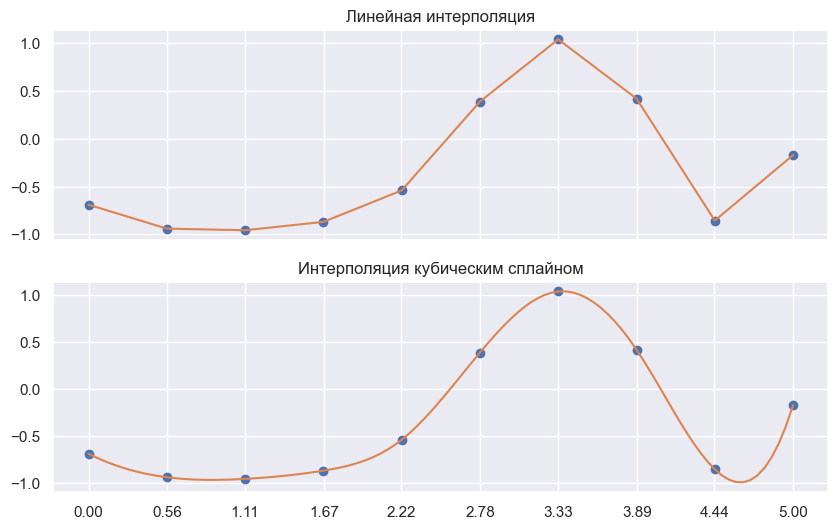

In [19]:
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt

# зададим 10 точек (узлов) в интервале от 0 до 5
n = 10
x = np.linspace(0, 5, n)
y = np.sin(x**2/3 + 4)+ 0.1 * np.random.randn(n)

# выведем на графике узлы
# и созданные по ним интерполирующие функции
xnew = np.linspace(0, 5, 100)

# вычислим линейный интерполянт
f1 = np.interp(xnew, x, y)
# и кубический сплайн
f3 = CubicSpline(x, y)

f, ax = plt.subplots(2, 1, sharex = True)
ax[0].plot(x, y, 'o', xnew, f1, '-')
ax[0].set(title = 'Линейная интерполяция')
ax[1].plot(x, y, 'o', xnew, f3(xnew), '-')
ax[1].set(title = 'Интерполяция кубическим сплайном', xticks = np.round(x, 2))

plt.show()

In [20]:
# создадим список из названий методов интерполяции,
# которые передадим в .interpolate()
methods = ['linear', 'polynomial', 'quadratic', 'cubic', 'spline']

In [21]:
# применим каждый из методов к данным о пассажирах
for m in methods:
  if m == 'polynomial':
    # для полиномиальной интерполяции нужно указать степень полинома
    # (пока поддерживаются только нечетные степени)
    passengers[m] = passengers.target.interpolate(method = m, order = 3)
  elif m == 'spline':
    # для сплайна порядок должен быть 1 <= k <= 5
    passengers[m] = passengers.target.interpolate(method = m, order = 5)
  else:
    passengers[m] = passengers.target.interpolate(method = m)

In [22]:
# сделаем то же самое с данными о рождаемости
for m in methods:
  if m == 'polynomial':
    births[m] = births.target.interpolate(method = m, order = 3)
  elif m == 'spline':
    births[m] = births.target.interpolate(method = m, order = 5)
  else:
    births[m] = births.target.interpolate(method = m)

### Сравнение методов

In [23]:
# импортируем функцию для расчета RMSE
from sklearn.metrics import root_mean_squared_error

In [ ]:
# напишем функцию для сравнения методов
def compare_methods(df):
  """Compare methods."""
  # в цикле list comprehension будем брать по одному столбцу
  # (итерируя по названиям столбцов)
  # и рассчитывать корень среднеквадратической ошибки
  results = [(method, np.round(root_mean_squared_error(df.reference, df[method]), 2)) for method in df.columns[3:]]
  # преобразуем получившийся список вначале в массив Numpy, затем в датафрейм
  results = pd.DataFrame(np.array(results), columns = ['Method', 'RMSE'])
  # отсортируем по размеру ошибки в возрастающем (по умолчанию) порядке
  results.sort_values(by = 'RMSE', inplace = True)
  # сбросим индекс
  results.reset_index(drop = True, inplace = True)
  return results

In [25]:
# сравним методы для данных о пассажирах
passengers_results = compare_methods(passengers)
passengers_results

,Method,RMSE
0,spline,12.29
1,polynomial,12.47
2,cubic,12.47
3,quadratic,12.72
4,linear,19.26
5,BFill,23.32
6,FFill,28.96
7,RollingMean,40.44
8,RollingMedian,43.35
9,FillMedian,49.79


In [26]:
# и рождаемости
births_results = compare_methods(births)
births_results

,Method,RMSE
0,FillMean,3.55
1,FillMedian,3.65
2,RollingMedian,3.81
3,RollingMean,3.89
4,linear,4.04
5,polynomial,4.22
6,quadratic,4.22
7,cubic,4.22
8,FFill,4.3
9,BFill,4.39


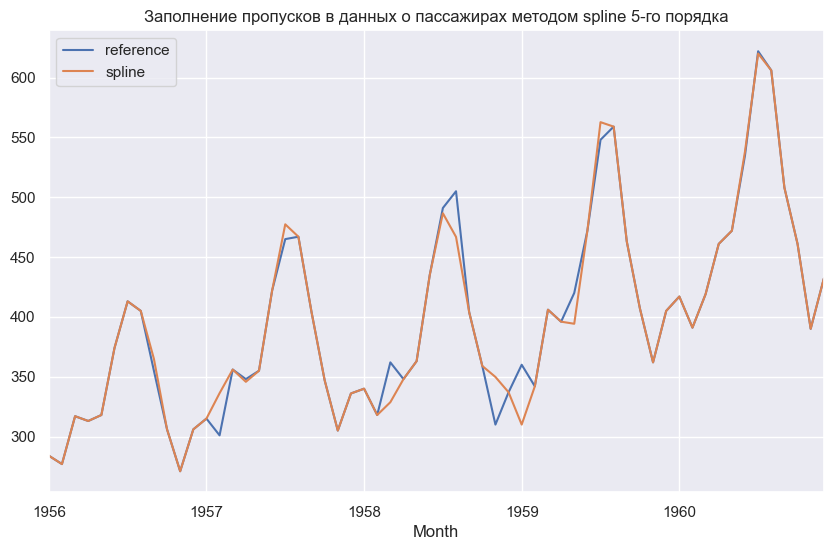

In [27]:
# выведем лидера по точности заполнения пропусков в данных о пассажирах
passengers[['reference', 'spline']].plot()
plt.title('Заполнение пропусков в данных о пассажирах методом spline 5-го порядка');

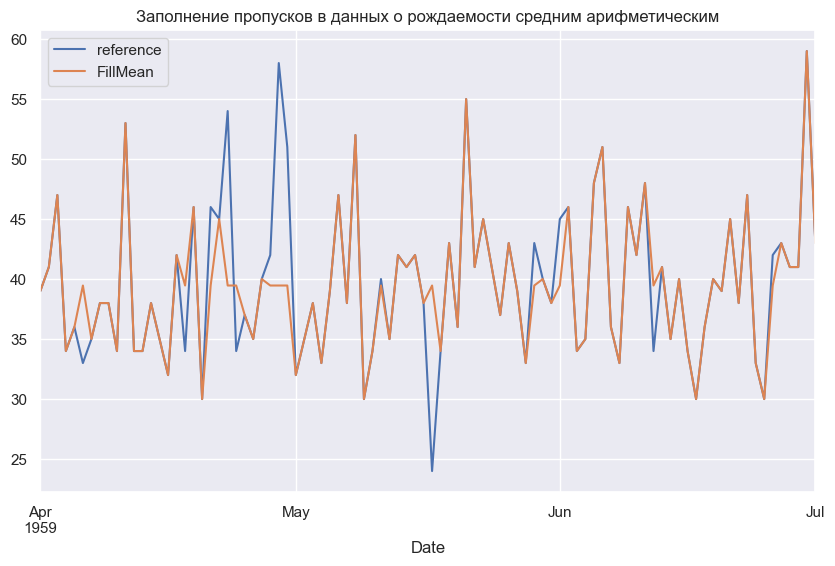

In [28]:
# сделаем то же самое для данных о рождаемости
births[['reference', 'FillMean']].plot()
plt.title('Заполнение пропусков в данных о рождаемости средним арифметическим');